# Representación Validación Cruzada

 Los resultados se han guardado en el archivo `final.rda` dentro de la carpeta ` Cross-validation/ `. Dentro de dicho archivo se encuentra una lista de `R` llamada `cross.val` con los siguientes valores:

> **metrics**: _data.frame_ con diferentes métricas para cada modelo.
>    * RMSE: $\sqrt{\frac{\sum_i^N{({pred}_i - {obs}_i)^2}}{N}}$
>    * bias: $\frac{\overline{pred}}{\overline{obs}}$
>    * cor1: Correlación de Pearson para los datos brutos de observación y predicción 
>    * cor2: Correlación de Pearson para los datos desestacionalizados de observación y predicción
>    * var.ratio: $\frac{var(pred)}{var(obs)}$
>
> **predictions**: _data.frame_ con las series temporales observadas (`obs`), predichas por el modelo (`pred`) y con el ajuste fino _qq.Mapping_ (`pred.qq`)
>
> **predictions.ds**: _data.frame_ con las series temporales desestacionalizadas observadas (`obs`), predichas por el modelo (`pred`) y con el ajuste fino _qq.Mapping_ (`pred.qq`)

Cabe destacar que se ha obtenido la correlación entre la predicción y la observación desestacionalizados debido a que la propia tendencia sinusoidal de las series temporales aportan una gran correlacion a los modelos simplemente teniendo en cuenta esto. 

## Filtrado de los Datos

Se han filtrado los datos eliminando todos aquellos valores de las variables objetivo (contaminantes) que se encontraran fuera de 5*IQR del IQR.

```R
    filter.IQR(data, columns=target, n=5)
```

$$
\begin{matrix}
    x > Q_1 - 5 \cdot IQR \\
    x < Q_3 + 5 \cdot IQR
\end{matrix} \Rightarrow x
$$

## Estaciones Utilizadas

Se han escogido al menos 10 estaciones de calidad del aire para cada contaminante teniendo en cuenta los siguientes aspectos:

   > Que tuviesen suficientes datos para dicho contaminante
   >
   > Se situase en una ciudad con una alta población 
   >
   > El conjunto de las estaciones de cada contaminante se situasen de manera homogénea por todo el territorio del país 

## _Leave One Group Out_
La validación se ha realizado con los datos del 2013 al 2019, realizando un _Leave One Group Out_ utilizando como test un año natural completo y como train el resto. Ésto se ha realizado de manera iterativa para todos los años disponibles. En las tablas de datos se indica el año utilizado de test en cada iteración.

## Técnicas

Las técnicas utilizadas en la validación han sido:

> **Vecinos más cercanos (knn)**: Para distintos vecinos cercanos `k = 1:10`
> 
> **randomForest (rf)**: Para dististintos número de árboles `ntree = 10, 20, 30, 50, 100, 150, 200`
>
> **Regresion Lineal (lm)**

La técnica utilizada se detalla en la columna `method` con los valores `("knn", "rf", "lm")`

## _qq Mapping_

Para cada uno de los modelos obtenidos se les ha aplicado un ajuste fino mediante _qq Mapping_ para tratar de mejorar los valores obtenidos para el ratio de varianza **var.ratio**, que es donde se ha visto que fallaban los modelos, y así intentar que el modelo sea capaz ade describir los picos de mayor intensidad del modelo. De esta forma se han obtenido los resultados de la validación cruzada con los datos sin dicho ajuste fino `qq.Mapping == "No"` y con dicho ajuste `qq.Mapping == "Yes"`. Para el ajuste mediante _qq.Mapping_ se han utilizado los 99 quantiles.

```R
downscaleR:::eqm(train.observation,
                 train.prediction,
                 test.prediction,
                 n.quantile=99,
                 precip=FALSE, pr.threshold=0,
                 extrapolation=""
                 ) 
```

## Dias Anteriores Meteo

Además, se ha probado añadiendo los datos meteorológicos de dias anteriores como outputs. En las tablas de resultados la columna `days` hace referencia a cuantos dias anteriores se han añadido, haciendo referencia el 0 a que solo se han tratado como outputs los datos meteorológicos del día. 

---

### Cargar paquetes

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(ggplot2))

suppressMessages(library(openair))

In [63]:
# Cambiar la apariencia de las graficas en jupyter
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

#### Notación en las gráficas

Se añade el formato correcto de cada una de las variables categóricas con el que deben aparecer en las gráficas. Si se quiere elimiar alguna de estas variables de las gráficas se puede hacer ahora y afectará al resto del notebook.

In [57]:
pollut.notation <- c("no" = expression(NO),
                     "no2" = expression(NO[2]),
                     "o3" = expression(O[3]),
                     "pm10" = expression(PM10),
                     "pm2.5" = expression(PM2.5)
                    )
method.notation <- c("lm" = expression(MLR),
                     "rf" = expression(RF),
                     "knn" = expression(KNN)
                    )
Error.notation <- c("bias" = expression(paste("Bias", " ratio [-]")),
                    "cor1" = expression(paste("Correlation", " [-]")),
                    "cor2" = expression(paste("Unseasonalised", " correlation", " [-]")),
                    "RMSE" = expression(paste("RMSE [", mu, "g", m^-3, "]")),
                    "var.ratio" = expression(paste("Variance", " ratio [-]"))
                   )
site.notation <- c("es0118a" = "Madrid, Escuelas Aguirre",  # NO2, NO, O3, PM10, PM2.5 
                   "es1938a" = "Madrid, Castellana",  # PM2.5
                   "es1438a" = "Barcelona, l'Eixample",  # NO2, NO
                   "es1239a" = "Valencia, Pista de Silla",  # NO2, NO, O3, PM2.5
                   "es1181a" = "Valencia, Quart de Poblet",  # PM10
                   "es0890a" = "Sevilla, Torneo",  # NO2, NO, O3
                   "es1047a" = "Zaragoza, Roger de Flor",  # NO2, NO, O3, PM10
                   "es1137a" = "Vigo, Arenal (COIA)",  # NO2, NO, O3, PM10, PM2.5
                   "es0110a" = "Bilbao, Erandio",  # PM2.5
                   "es1244a" = "Bilbao, Mazarredo",  # NO2, NO, PM10
                   "es1632a" = "Valladolid, Vega Sicilia",  # O3, PM10
                   "es1631a" = "Valladolid, Arco de Ladrillo",  # NO2, NO, PM2.5
                   "es1580a" = "Santander, Centro",  # NO2, NO, PM10
                   "es1610a" = "Palma, Forens",  # NO2, NO, O3, PM10
                   "es1635a" = "Alicante, Alacant-El Pla",  # O3
                   "es1697a" = "San Sebastian, Avenida Tolosa",  # O3, PM2.5
                   "es1272a" = "Gijon, Constitucion",  # O3, PM10, PM2.5
                   "es1340a" = "Huelva, Pozo Dulce",  # PM10
                   "es1096a" = "Ourense, Gomez Franqueira",  # PM2.5
                   "es1492a" = "Vitoria, Tres Marzo"  # PM2.5
                   )

Se cargan los resultados de la validación cruzada

In [58]:
HOME <- "~/Repositories/AirQualityCOVID/"
setwd(HOME)
load(paste(HOME, "data/Cross-validation/final.rda", sep=""))

---

## Métricas

Para el estudio de la calidad de los modelos obtenidos con cada una de las técnicas y parámetros se han calculado una serie de métricas a partir de los datos observados reales en el conjunto de test y las predicciones del modelo para el mismo intervalo.

* **RMSE** (_Root Mean Square Error_): $\sqrt{\frac{\sum_i^N{({pred}_i - {obs}_i)^2}}{N}}$
* **bias**: $\frac{\overline{pred}}{\overline{obs}}$
* **cor1**: Correlación de Pearson para los datos brutos de observación y predicción 
* **cor2**: Correlación de Pearson para los datos desestacionalizados de observación y predicción
* **var.ratio**: $\frac{var(pred)}{var(obs)}$

Estos valores se muestran en columnas para cada error en `cross.val$metrics`. Sin embargo, para facilitar su representación en _Boxplots_ mediante el paquete `ggplot2` se han pivotado dichas columnas para obtener un `data.frame` final con todos los valores de todas métricas en una misma columna **Err.Val** y otra columna indicando el tipo de métrica **Error**.

<div align = "center" style="display:flex; width: 500px; height: 200px;">
    
<table align="left" style="display: grid; width:55%; margin-top: 50px;">
<tr style="border-bottom: 1px solid black;">
    <th style="border-right: 1px solid black;">...</th>
    <th style="border-right: 1px solid black;">bias</th> 
    <th style="border-right: 1px solid black;">cor1</th>
    <th style="border-right: 1px solid black;">cor2</th>
    <th style="border-right: 1px solid black;">RMSE</th> 
    <th>var.ratio</th>
</tr>

<tr>
    <td style="border-right: 1px solid black;">...</td>
    <td style="border-right: 1px solid black;">0.999</td>
    <td style="border-right: 1px solid black;">0.907</td>
    <td style="border-right: 1px solid black;">0.876</td>
    <td style="border-right: 1px solid black;">2.173</td>
    <td>0.837</td>
</tr>
<tr>
    <td style="border-right: 1px solid black;">...</td>
    <td style="border-right: 1px solid black;">...</td>
    <td style="border-right: 1px solid black;">...</td>
    <td style="border-right: 1px solid black;">...</td>
    <td style="border-right: 1px solid black;">...</td>
    <td>...</td>
</tr>
    
</table>
   
<p align="center" style="width: 5%; margin-top: 70px;">
    &#8649;
</p>
    
<table align="right" style="width:40%;">
<tr style="border-bottom: 1px solid black;">
    <th style="border-right: 1px solid black;">...</th>
    <th style="border-right: 1px solid black;">Error</th> 
    <th>Err.Val</th>
</tr>
<tr>
    <td style="border-right: 1px solid black;">...</td>
    <td style="border-right: 1px solid black;">bias</td>
    <td>0.999</td>
</tr>
<tr>
    <td style="border-right: 1px solid black;">...</td>
    <td style="border-right: 1px solid black;">cor1</td>
    <td>0.907</td>
</tr>
<tr>
    <td style="border-right: 1px solid black;">...</td>
    <td style="border-right: 1px solid black;">cor2</td>
    <td>0.876</td>
</tr>
<tr>
    <td style="border-right: 1px solid black;">...</td>
    <td style="border-right: 1px solid black;">RMSE</td>
    <td>2.173</td>
</tr>
<tr>
    <td style="border-right: 1px solid black;">...</td>
    <td style="border-right: 1px solid black;">var.ratio</td>
    <td>0.837</td>
</tr>
<tr>
    <td style="border-right: 1px solid black;">...</td>
    <td style="border-right: 1px solid black;">...</td>
    <td>...</td>
</tr>    
</table>
</div>

En el `data.frame` original se ha incluido el año del conjunto de test para cada caso. Sin embargo, para su representación se ha realizado la media de los resultados para todos los años de la validación cruzada.

Se ha incluido el código para seleccionar qué estaciones, contaminantes o métricas se van a analizar.

In [59]:
pivot.metrics <- cv.results$metrics %>%
        # Pivotar la Tabla con los valores de las metricas
        pivot_longer(cols = 7:ncol(cv.results$metrics),
                     names_to = "Error", values_to = "Err.Val") %>%
        # Calcular los valores medios de la cv 
        #group_by(method, days, site, 
        #         variable, param, qq.Mapping, Error) %>%
        #summarise(Err.Val = mean(Err.Val)) %>%
        # Filtrar los datos si no se desea representar todos los datos
        filter(site %in% names(site.notation),
               variable %in% names(pollut.notation),
               Error %in% names(Error.notation)
              )

Se filtran que modelos se quieren estudiar en función de técnica (**method**), los dias meteorologicos anteriores añadidos (**days**), los parámetros del modelo (**param**, _k_ para `knn` y _ntree_ para `rf`) y si se le ha aplicado el ajuste fino _qq.Mapping_. 

Esto permite no solo estudiar cada técnica utilizada por separado, sino comparar los resultados para distintas técnicas.

In [60]:
dat.df <- rbind(pivot.metrics %>%
                    filter(method == "lm",
                           days == 3,
                           qq.Mapping == "Yes",
                          ),
                #pivot.metrics %>%
                #    filter(method == "glm",
                #           days == 3,
                #           qq.Mapping == "Yes",
                #          ),
                pivot.metrics %>%
                    filter(method == "knn",
                           days == 0,
                           param == 10,
                           qq.Mapping == "Yes",
                          ),
                pivot.metrics %>%
                    filter(method == "rf",
                           days == 0,
                           param == 100,
                           qq.Mapping == "Yes"
                          )
               ) %>% arrange(variable, Error)


#dat.df$variable <- factor(dat.df$variable, 
 #                         labels=pollut.notation)

#dat.df$method <- factor(dat.df$method, 
#                        labels=c("lm"="lm", "rf"="rf", "knn"="knn"))

Las gráficas se organizan por columas según el contamiante y por filas según la métrica.

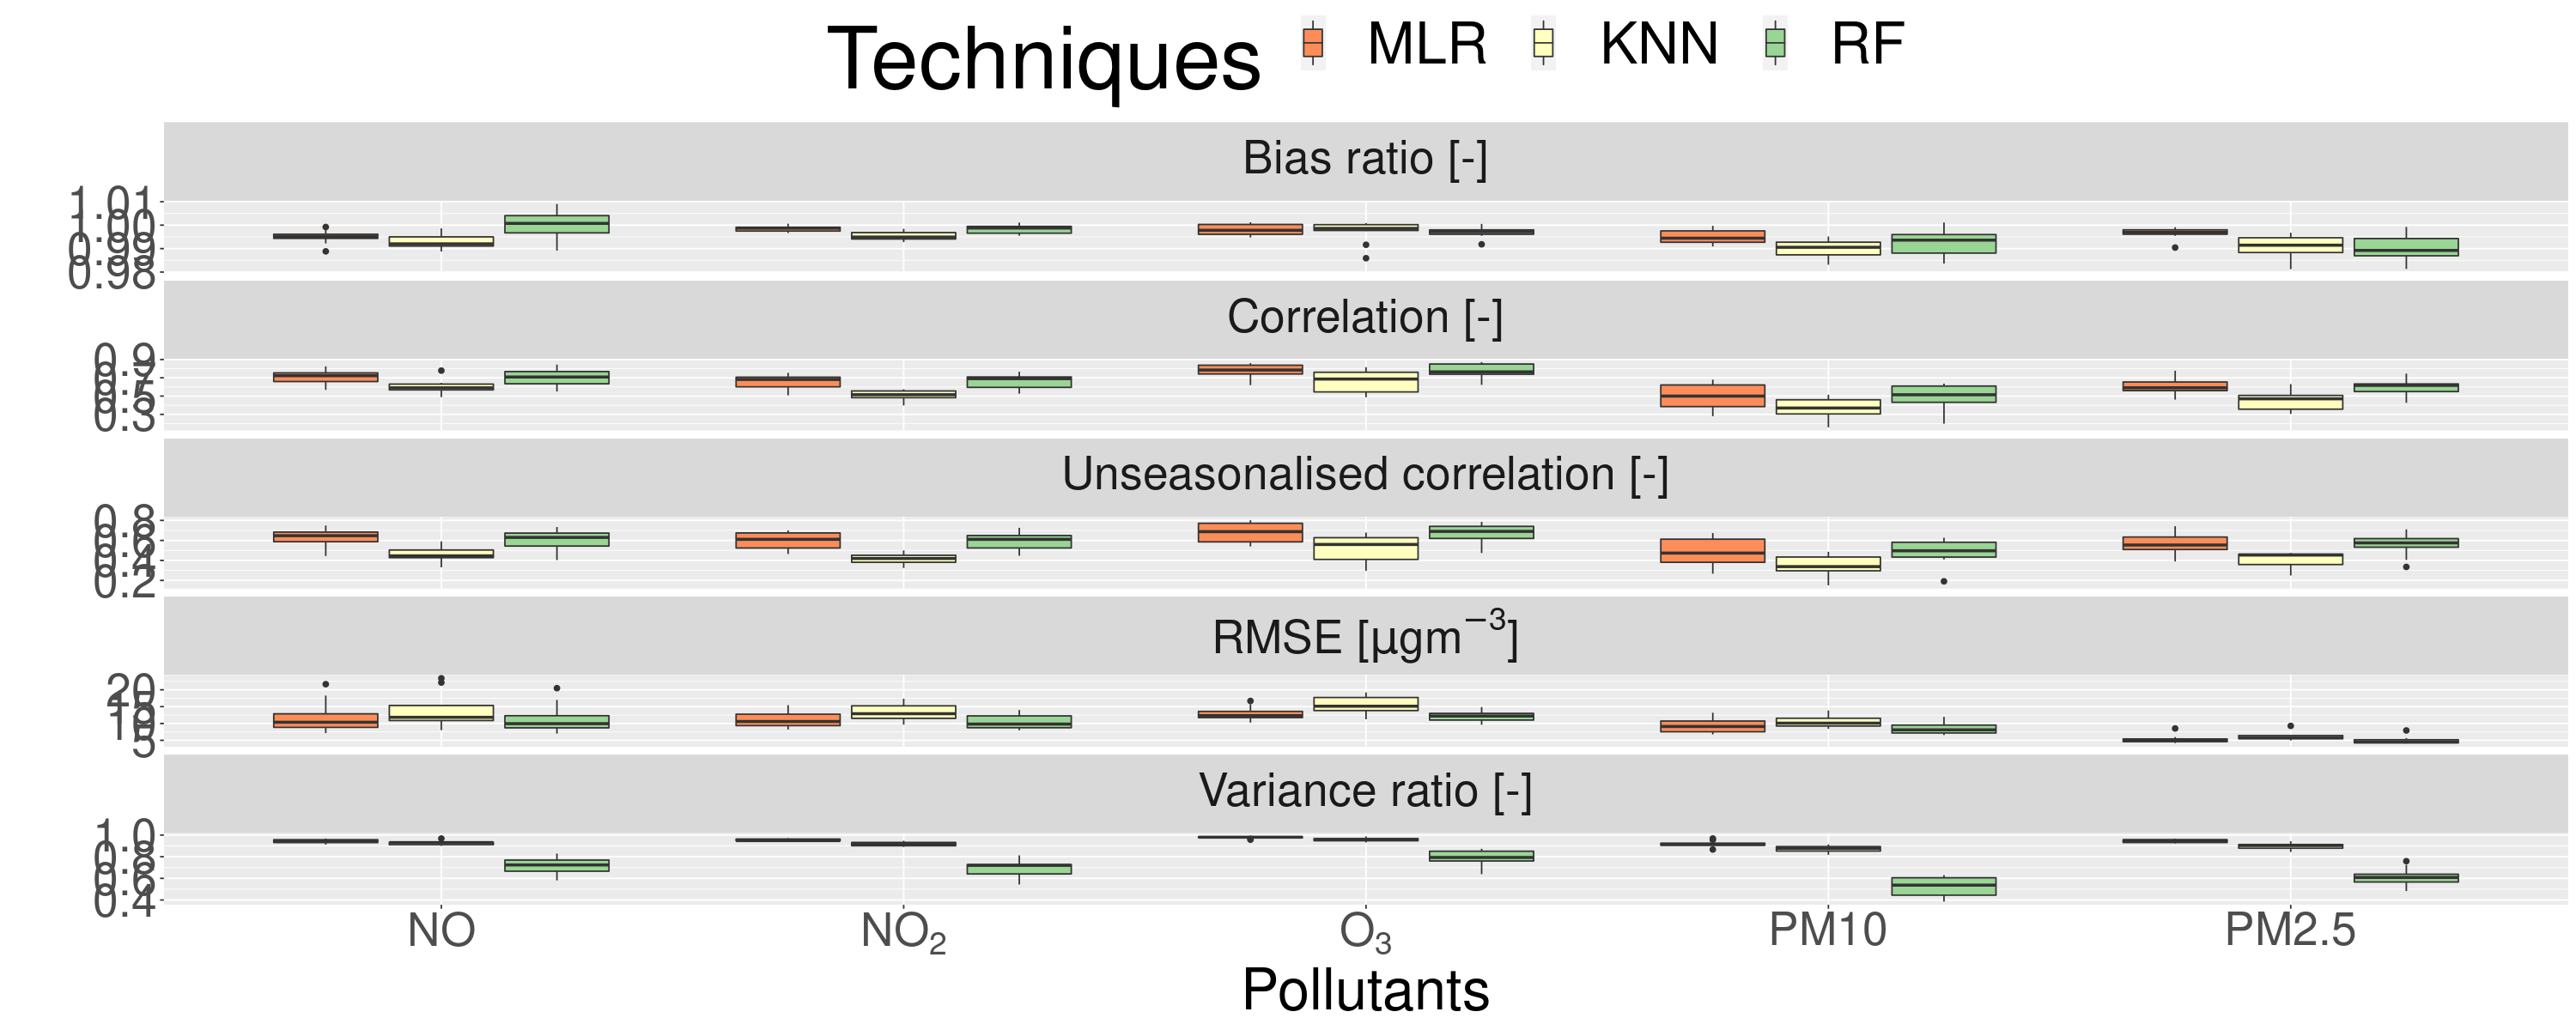

In [64]:
dat.df$Error <- factor(dat.df$Error, 
                       labels=Error.notation)

plt.final <- ggplot(data=dat.df) +
    geom_boxplot(aes(x=variable, 
                     y=Err.Val, 
                     fill=method, 
                     #color=qq.Mapping
                    )) +
    facet_wrap(~Error, 
               ncol=1, scale="free_y", 
               labeller = labeller(variable=label_parsed,
                                   Error=label_parsed)) +
    theme(legend.position="top",
          text = element_text(size=40),
          legend.text = element_text(size=40),
          legend.title = element_text(size=60),
         ) +
    scale_x_discrete(name="Pollutants", 
                     labels = pollut.notation
                    ) +
    scale_y_continuous(name="") +
    scale_fill_brewer(name="Techniques", 
                      labels = method.notation,
                      palette="Spectral") +
    scale_color_grey(name="",
                     labels = c("Yes" = "With q-q mapping", 
                                "No" = "Without q-q mapping"))

ggsave(plot = plt.final, 
       filename = "Plots/Cross-Validation/cv-final.png",
       #filename = "doc/paper/Figures/cv-lm-qq.png",
       width = 30, #40 
       height = 15) #30

plt.final

In [13]:
dat.df %>%
    group_by(method, variable, Error, param, qq.Mapping) %>%
    summarise(Err.Val = mean(Err.Val, na.rm=T)) %>%
    pivot_wider(names_from = c("Error"), values_from = "Err.Val") %>%
    arrange(variable)

`summarise()` has grouped output by 'method', 'variable', 'Error', 'param'. You can override using the `.groups` argument.



method,variable,param,qq.Mapping,Err.Val
<fct>,<chr>,<fct>,<fct>,<dbl>


* <h3> Regresión Linea <i><b>lm</b></i></h3>

    * _qq.Mapping_: 
        
        Mejora notablemente el **var.ratio** que pasa de 0.5 $\rightarrow$ 1 mientras que en el bias la mejora es menor debido a que ya alcanzaba unos valores muy buenos. Las correlaciones para $O_3$, PM10, PM2.5 no sufren un gran cambio, mientras que los $NO$ y $NO_2$ aumentan su correlación. El **RMSE** por otro lado aumenta con el _qq.Mapping_ excepto en el $NO$ que se mantiene igual.

    * _days_
        
        Para los contaminantes PM10 y PM2.5 no se aprecia ningún cambio al incluir los datos meteorológicos de dias anteriores. Para $NO$, $NO_2$ y $O_3$ sí que mejoran las correlaciones al meter más días meteorológicos, siendo el mayor cambio al pasar de 0 $\rightarrow$ 1.
 

* <h3> Vecinos Más Cercanos <i><b>knn</b></i></h3>

    * _days_: 
        
        Al aumentar el número de dias de datos meteorologicos los modelos empeoran, ya que esta técnica le da los mismos pesos a todos lo predictores, tratando con la misma importancia los datos meteorológicos del día que los de los dias anteriores.

    * _param_:
        
        Se observa una gran mejora al aumentar el número de vecinos tanto para las correlaciones como para el **RMSE**. Sin embargo el **var.ratio** empeora al aumentar el número de vecinos.

    * _qq.Mapping_: 
        
        Para el caso del **bias** no se aprecia mucha mejora pero sí se aprecia que estrecha los boxplots. Las correlaciones disminuyen un poco al aplicar el ajuste, pero se sigue apreciando la mejora al aumentar `k`. 
        
        El _qq.Mapping_ suaviza la caida del **RMSE** y del **var.ratio** al aumentar `k`.
  

* <h3> RandomForest <i><b>rf</b></i></h3>

    * _days_: 
    
        > _Debido al alto tiempo de calculo, este analisis solo se ha hecho para la estacion de Madrid `es0118a` y sus resultados se encuentran en el archivo `Cross-validation/rf-Madrid.rda`_.    
       
        No se puede obtener una conclusión del efecto de añadir más dias de datos meteorológicos a partir de los resultados para la estación de Madrid ya que se observan diferentes efectos en las distintas métricas para cada contaminante y en función del parámetro `ntree`.
       
    * _param_:
       
        Se observa una mejora al aumentar el número de árboles `ntree` tanto para las correlaciones como para el **RMSE** y el **bias**. Sin embargo, el **var.ratio** empeora al aumentar `ntree`. Esta mejora se suaviza a partir de `ntree = 50`.
        
    * _qq.Mapping_:
    
        Si bien sí mejora tanto el **bias** como el **var.ratio**, no evita que el **var.ratio** empeore al aumentar `ntree`. Por otro lado el efecto del _qq Mapping_ para las correlaciones y el **RMSE**, pese a que es a peor, es muy pequeño.

---

## Predicciones

In [65]:
predict.df <- cv.results$series %>%
                filter(site %in% names(site.notation)[1],
                       variable %in% names(pollut.notation),
                      )

In [66]:
predict.df <- rbind(predict.df %>%
                        filter(method == "lm",
                               days == 3,
                              )#,
                    #predict.df %>%
                    #    filter(method == "knn",
                    #           days == 0,
                    #           param == 10,
                    #          ),
                    #predict.df %>%
                    #    filter(method == "rf",
                    #           days == 0,
                    #           param == 10,
                    #          )
                   )

### Series Temporales

Se representan las series temporales predichas como conjunto de test por cada modelo y con el ajuste fino _qq Mapping_ junto con las series temporales observadas (en negro)

Las gráficas se sitúan por filas según el contaminante.

In [67]:
predict.df$variable <- factor(predict.df$variable, 
                              labels=pollut.notation)

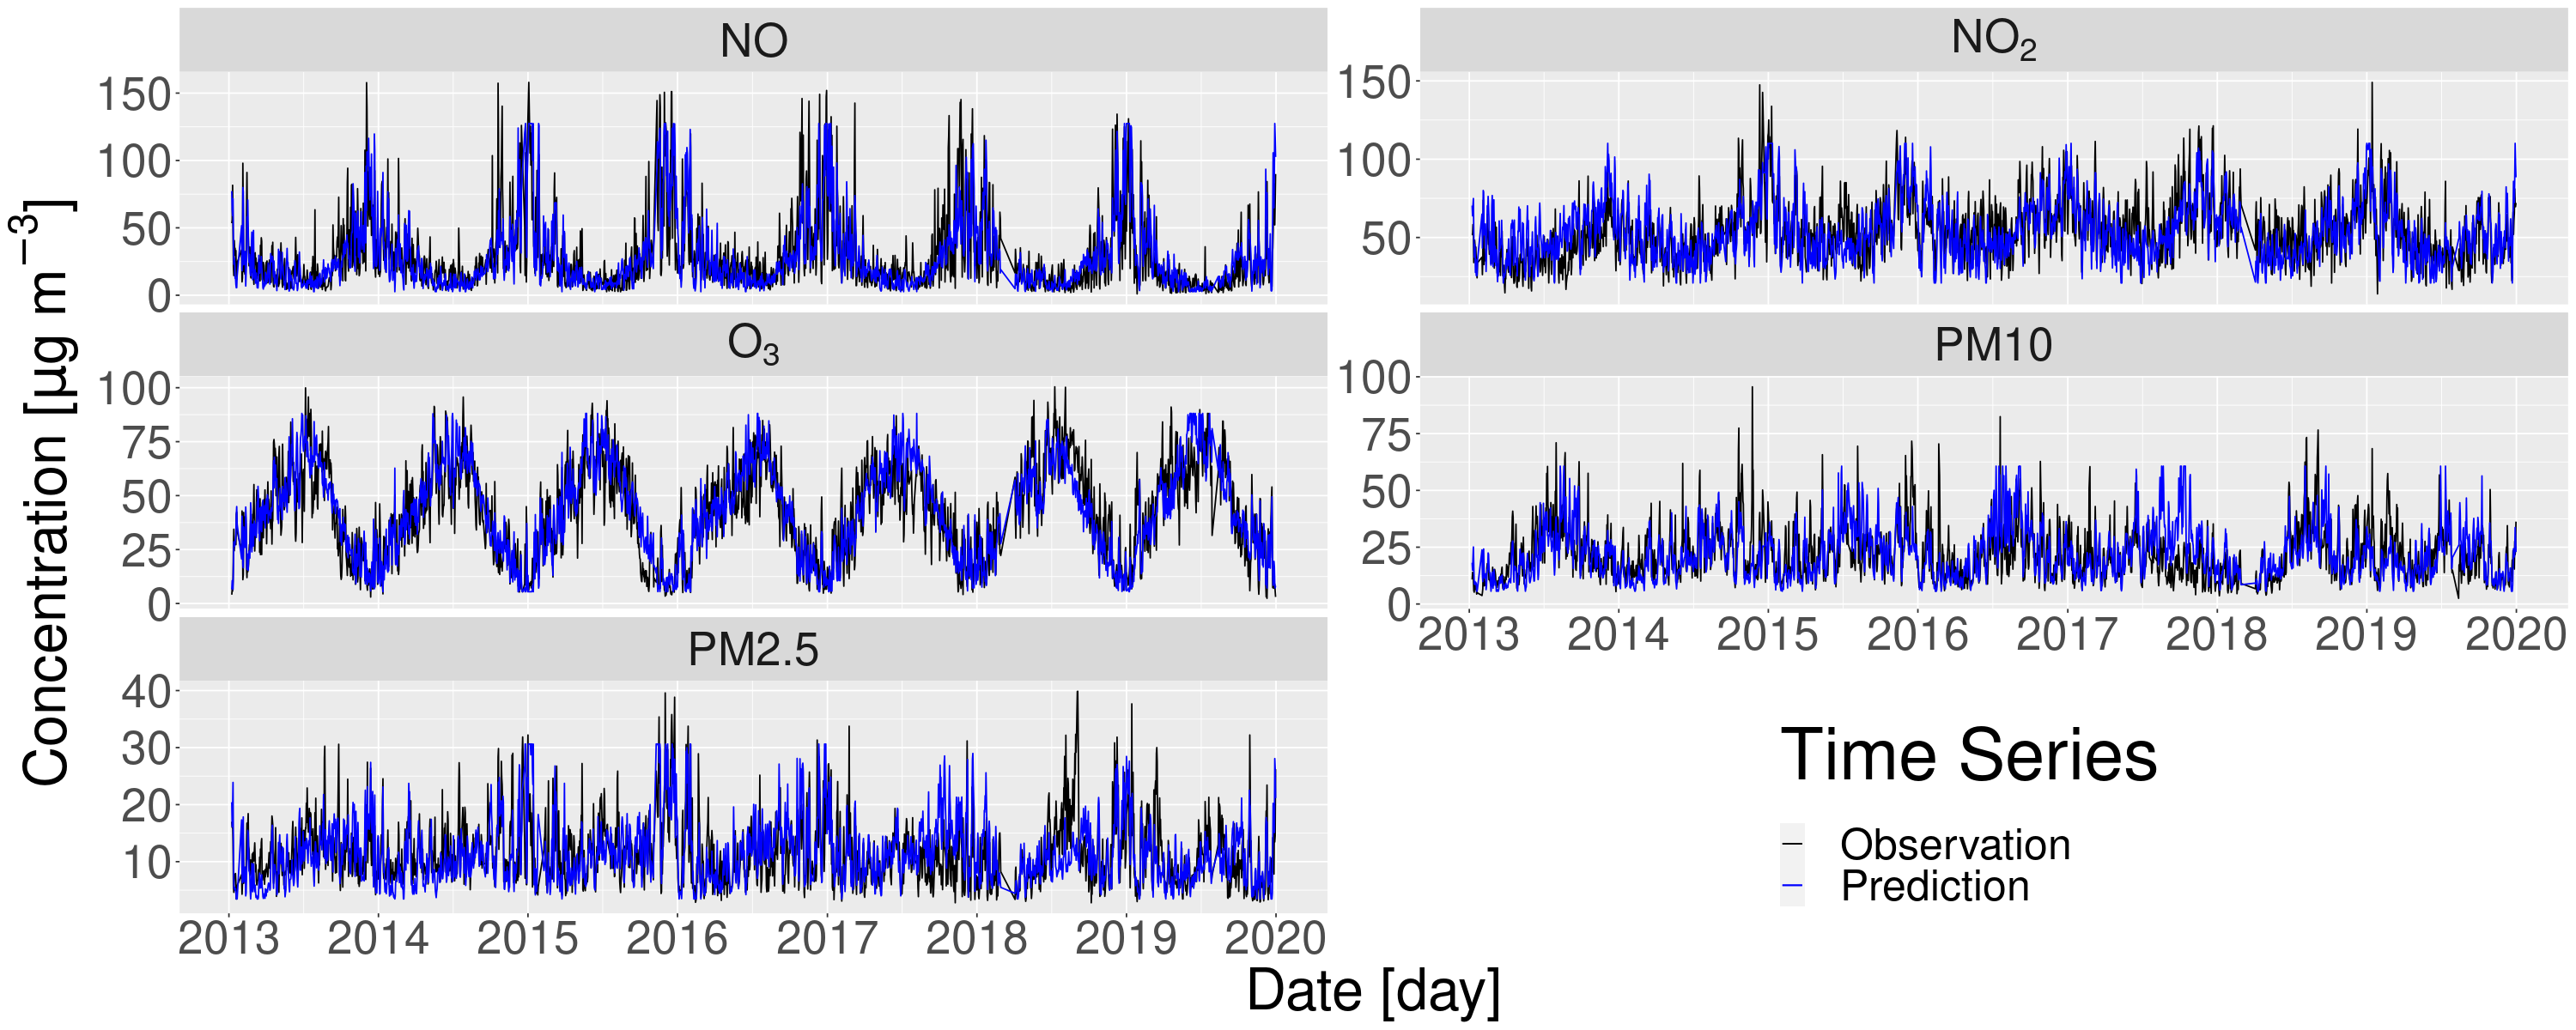

In [71]:
plt.serie <- ggplot(data=predict.df %>%
                           filter(lubridate::year(date) < 2020)) +
    geom_line(aes(x=date, y=obs, color = "Observation")) +
    geom_line(aes(x=date, y=pred.qq, color = "Prediction")) +
    facet_wrap(~variable, 
               ncol=2, scale="free_y", 
               labeller = labeller(variable=label_parsed)) +
    scale_color_manual(name="Time Series", 
                       values = c("Prediction" = "blue",
                                  "Observation" = "black")) +
    scale_x_date(name="Date [day]",
                 date_breaks = "1 year",
                 date_labels = "%Y") +
    scale_y_continuous(name=expression(paste("Concentration [", mu, "g ", m^-3, "]"))) +
    theme(legend.position=c(0.75,0.12),
          #legend.position="top",
          legend.text = element_text(size=30),
          legend.title = element_text(size=50),
          text = element_text(size=40),
         )

ggsave(plot = plt.serie, 
       filename = "doc/paper/Figures/serie.png", 
       width = 25, height = 10)

plt.serie

#### Resolucion Bisemanal

In [32]:
test <- predict.df %>%
            rename(value = pred.qq) %>%
            timeAverage(avg.time = "3 day", 
                        type = c("days", "site", "variable", "param", "method"))
test$date <- lubridate::ymd(test$date)

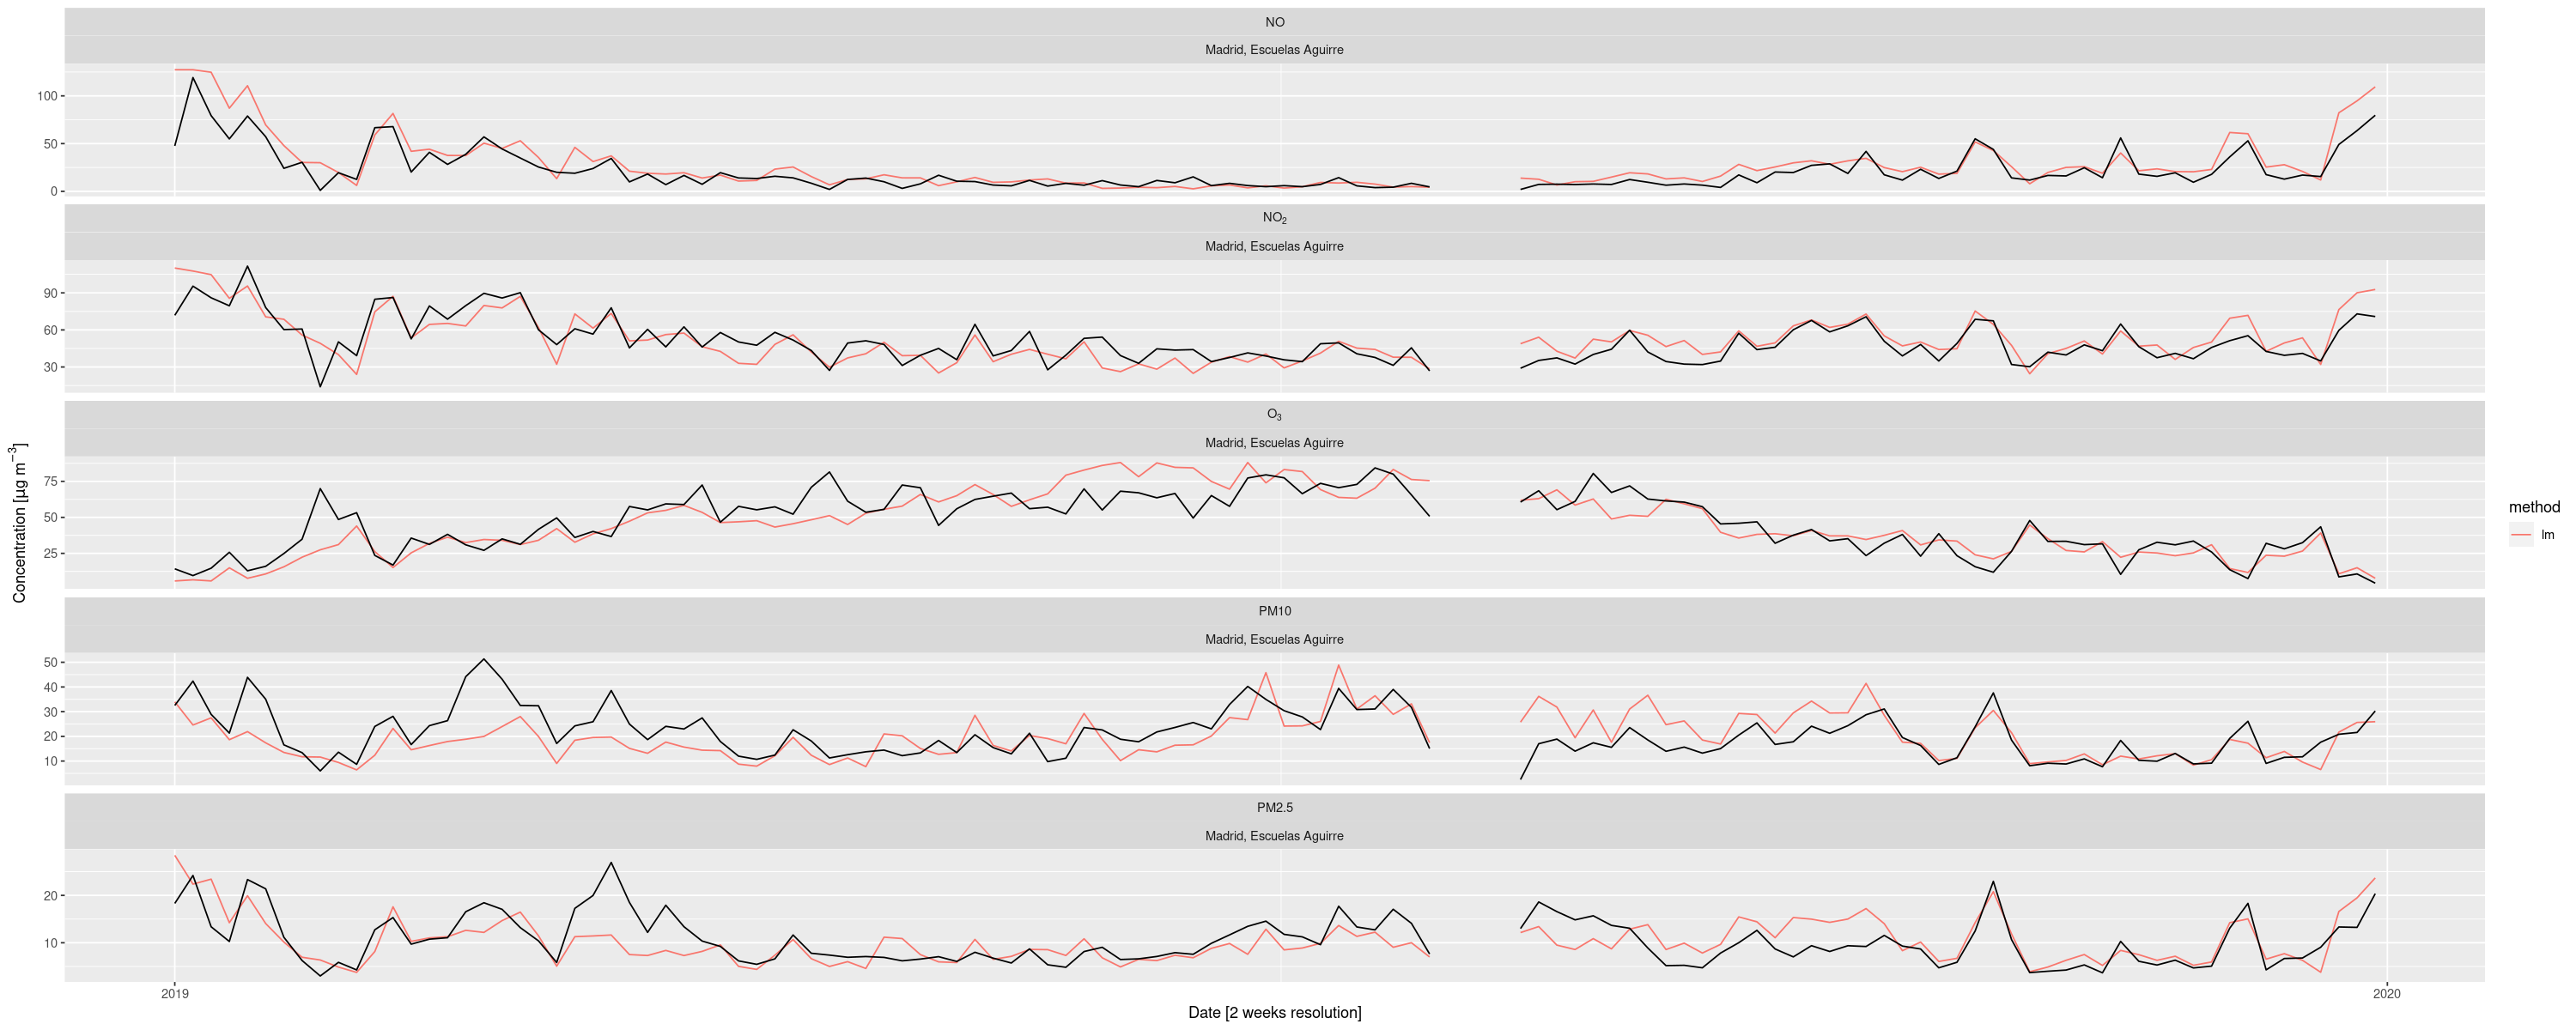

In [34]:
ggplot(data=test %>%
       filter(lubridate::year(date) > 2018)) +
    geom_line(aes(x=date, y=value, color = method)) +
    geom_line(aes(x=date, y=obs), color = "black") +
    facet_wrap(~variable+site,
               ncol=1, scale = "free_y",
               labeller=labeller(variable=label_parsed,
                                   site=site.notation)) +
    scale_x_date(name="Date [2 weeks resolution]",
                 date_breaks = "1 year",
                 date_labels = "%Y") +
    scale_y_continuous(name=expression(paste("Concentration [", mu, "g ", m^-3, "]")))

### Distribucion de los datos

Se representan las distribuciones de las predicciones para cada contaminante en cada estación junto con los datos observados (en negro). El ajuste fino por _qq Mapping_ mejora notablemente las distribuciones de las predicciones asemejandolas a la distribucion de las observaciones.

Las gráficas se sitúan por filas según el contaminante.

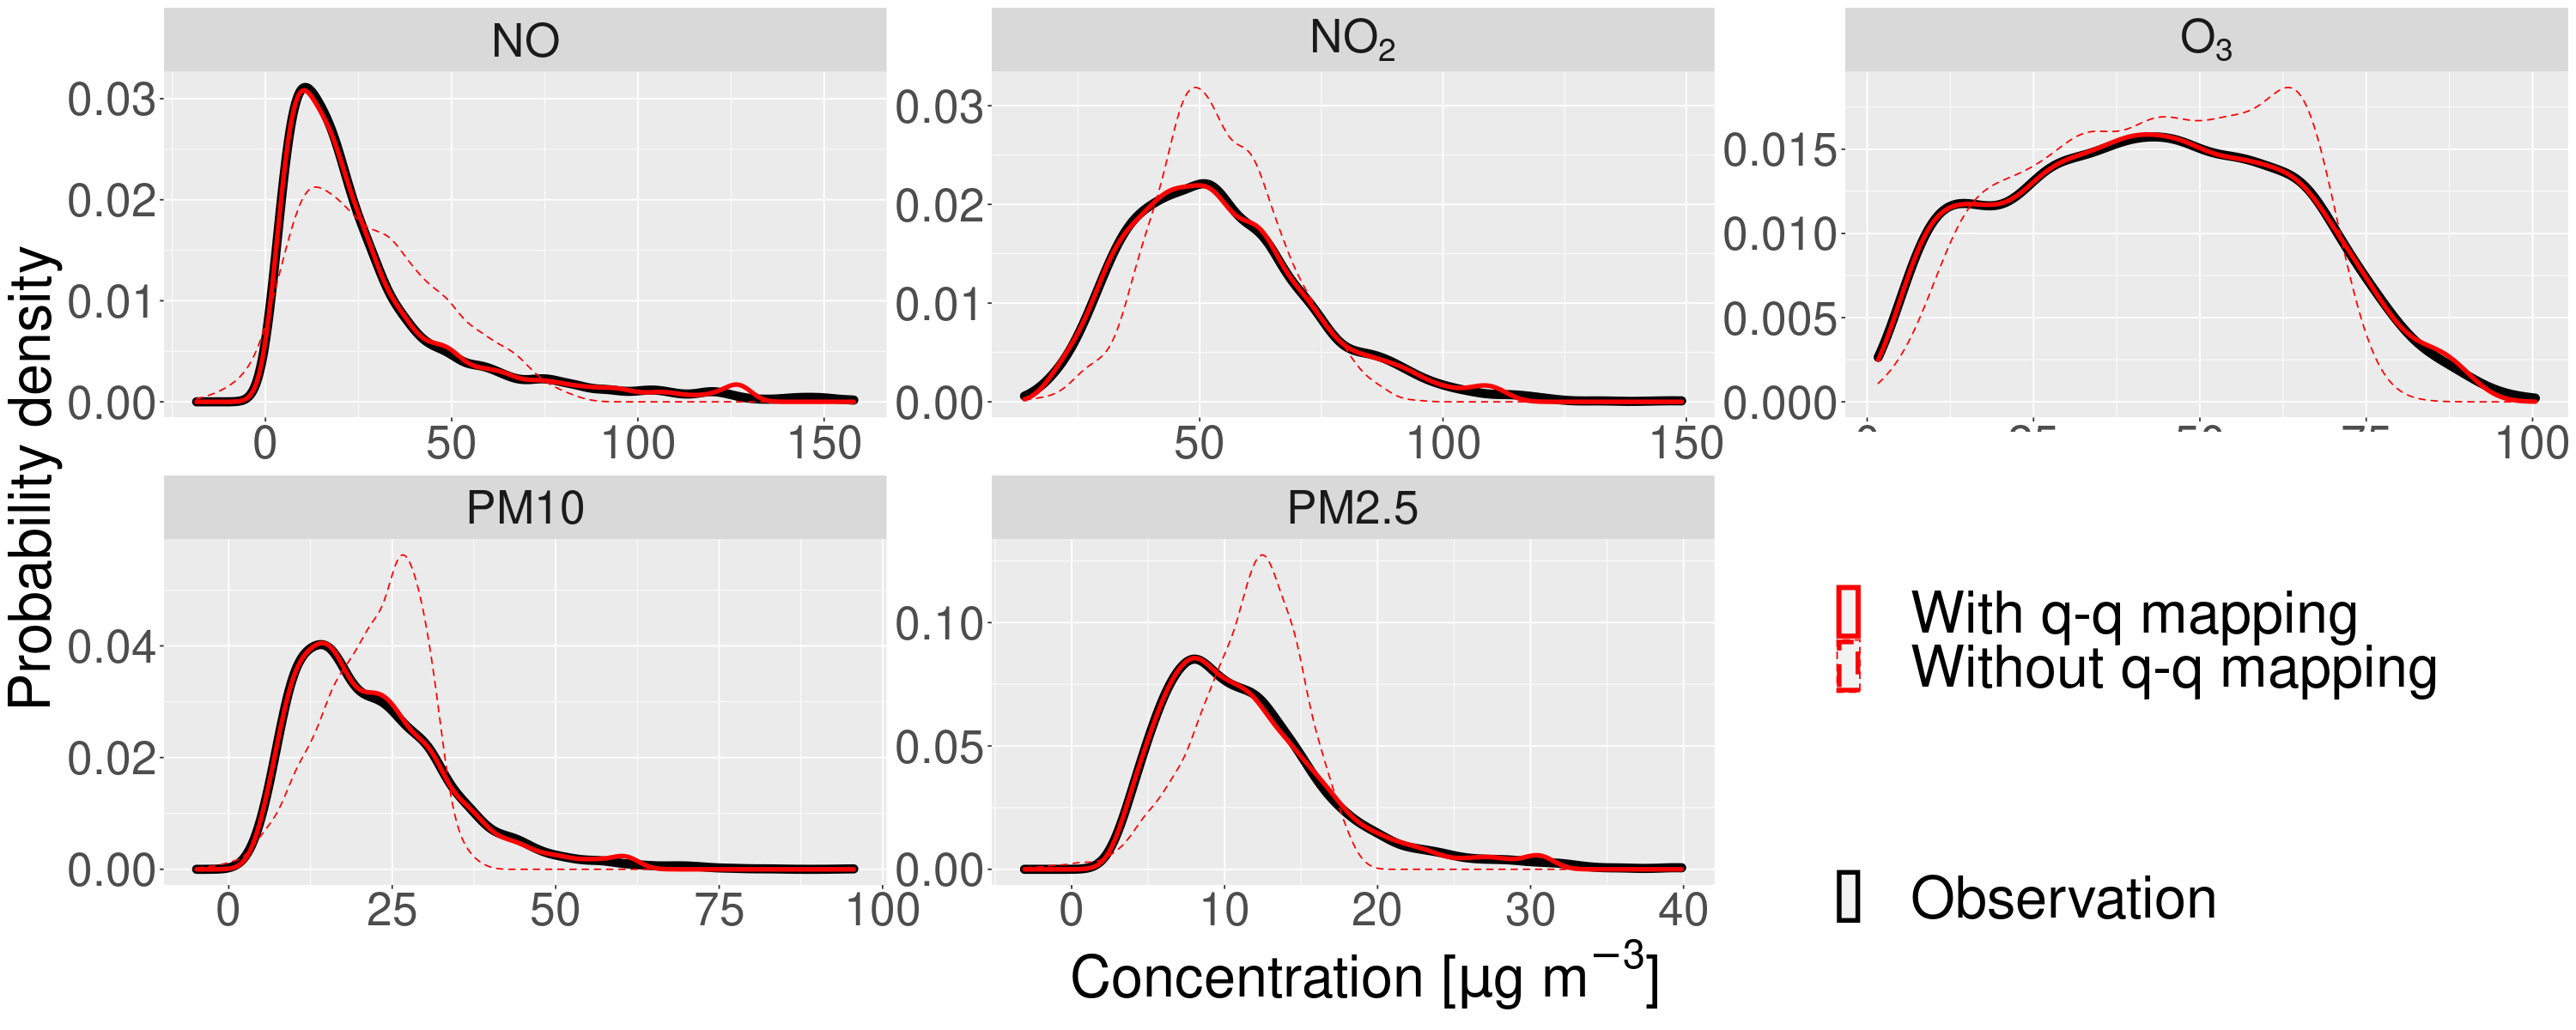

In [31]:
plt.dens <- ggplot(data=predict.df) +
    scale_linetype_manual(name="",
                          values = c("With q-q mapping" = "solid", 
                                     "Without q-q mapping"="dashed")) +
    scale_color_manual(name="",
                       values = c("Observation"="black")) +
    geom_density(aes(x=obs, color="Observation"), size=3) +
    geom_density(aes(x=pred.qq,
                     #color=method,
                     linetype="With q-q mapping"),
                 color="red", 
                 size=1.5) +
    geom_density(aes(x=pred,
                     #color=method,
                     linetype="Without q-q mapping"),
                 color="red", 
                 size=0.5) +
    facet_wrap(~variable, 
               ncol = 3, scale="free",
               labeller = labeller(variable=label_parsed)) +
    scale_x_continuous(name=expression(paste("Concentration [", mu, "g ", m^-3, "]"))) +
    scale_y_continuous(name="Probability density") +
    theme(legend.position=c(0.82,0.25),
          text = element_text(size=40),
          legend.text = element_text(size=40),
          legend.title = element_text(size=70),
         )

ggsave(plot = plt.dens, filename = "doc/paper/Figures/density.png", width =30, height = 15)

plt.dens